In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.layers import Input
from keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import initializers

In [40]:
np.random.seed(10)

# The dimension of our random noise vector.
random_dim = 100


In [41]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # normalize our inputs to be in the range[-1, 1]
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

In [47]:
def get_optimizer():
    #return Adam(learning_rate=0.0002, beta_1=0.5)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    return opt
def get_generator():
    generator = Sequential()
    generator.add(Dense(256, input_dim=random_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    opt=get_optimizer()
    generator.compile(loss='binary_crossentropy', optimizer=opt)
    return generator

def get_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(1, activation='sigmoid'))
    opt=get_optimizer()
    discriminator.compile(loss='binary_crossentropy', optimizer=opt)
    return discriminator

In [48]:
def get_gan_network(discriminator, random_dim, generator):
    # We initially set trainable to False since we only want to train either the
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    opt=get_optimizer()
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    return gan

In [49]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [50]:
def train(epochs=1, batch_size=128):
    # Get the training and testing data
    x_train, y_train, x_test, y_test = load_minst_data()
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size

    # Build our GAN netowrk
    #adam = get_optimizer()
    generator = get_generator()
    discriminator = get_discriminator()
    gan = get_gan_network(discriminator, random_dim, generator)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
            #gan.fit(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)


--------------- Epoch 1 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|▏                                                                                 | 1/468 [00:03<29:34,  3.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|▎                                                                                 | 2/468 [00:05<17:50,  2.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  1%|▌                                                                                 | 3/468 [00:06<13:57,  1.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  1%|▋                                                                                 | 4/468 [00:07<12:12,  1.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  1%|▉                                                                                 | 5/468 [00:08<11:27,  1.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  1%|█                                                                                 | 6/468 [00:10<10:47,  1.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  1%|█▏                                                                                | 7/468 [00:11<10:28,  1.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  2%|█▍                                                                                | 8/468 [00:12<10:14,  1.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  2%|█▌                                                                                | 9/468 [00:13<10:06,  1.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  2%|█▋                                                                               | 10/468 [00:15<10:00,  1.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


  2%|█▉                                                                               | 11/468 [00:16<09:59,  1.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  3%|██                                                                               | 12/468 [00:17<09:55,  1.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  3%|██▎                                                                              | 13/468 [00:19<09:58,  1.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  3%|██▍                                                                              | 14/468 [00:20<10:03,  1.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  3%|██▌                                                                              | 15/468 [00:22<10:28,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  3%|██▊                                                                              | 16/468 [00:23<10:08,  1.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  4%|██▊                                                                            | 17/468 [01:43<3:08:16, 25.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  4%|███                                                                            | 18/468 [01:44<2:13:01, 17.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|███▏                                                                           | 19/468 [01:44<1:34:19, 12.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|███▍                                                                           | 20/468 [01:45<1:07:18,  9.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  4%|███▋                                                                             | 21/468 [01:46<48:23,  6.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|███▊                                                                             | 22/468 [01:46<35:11,  4.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|███▉                                                                             | 23/468 [01:47<25:55,  3.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  5%|████▏                                                                            | 24/468 [01:47<19:27,  2.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  5%|████▎                                                                            | 25/468 [01:48<15:00,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|████▌                                                                            | 26/468 [01:49<11:51,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|████▋                                                                            | 27/468 [01:49<09:40,  1.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  6%|████▊                                                                            | 28/468 [01:50<08:15,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|█████                                                                            | 29/468 [01:51<07:11,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


  6%|█████▏                                                                           | 30/468 [01:51<06:21,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|█████▎                                                                           | 31/468 [01:52<05:51,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|█████▌                                                                           | 32/468 [01:53<05:24,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|█████▋                                                                           | 33/468 [01:53<05:10,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|█████▉                                                                           | 34/468 [01:54<05:06,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  7%|██████                                                                           | 35/468 [01:54<04:58,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|██████▏                                                                          | 36/468 [01:55<04:50,  1.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|██████▍                                                                          | 37/468 [01:56<04:42,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|██████▌                                                                          | 38/468 [01:56<04:36,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  8%|██████▊                                                                          | 39/468 [01:57<04:33,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|██████▉                                                                          | 40/468 [01:58<04:31,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|███████                                                                          | 41/468 [01:58<04:30,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|███████▎                                                                         | 42/468 [01:59<04:31,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|███████▍                                                                         | 43/468 [02:00<04:33,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  9%|███████▌                                                                         | 44/468 [02:00<04:32,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|███████▊                                                                         | 45/468 [02:01<04:30,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 10%|███████▉                                                                         | 46/468 [02:01<04:27,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|████████▏                                                                        | 47/468 [02:02<04:26,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|████████▎                                                                        | 48/468 [02:03<04:24,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 10%|████████▍                                                                        | 49/468 [02:03<04:22,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|████████▋                                                                        | 50/468 [02:04<04:23,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|████████▊                                                                        | 51/468 [02:05<04:21,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█████████                                                                        | 52/468 [02:05<04:18,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 11%|█████████▏                                                                       | 53/468 [02:06<04:15,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█████████▎                                                                       | 54/468 [02:06<04:18,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█████████▌                                                                       | 55/468 [02:07<04:16,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█████████▋                                                                       | 56/468 [02:08<04:12,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|█████████▊                                                                       | 57/468 [02:08<04:13,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 12%|██████████                                                                       | 58/468 [02:09<04:13,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|██████████▏                                                                      | 59/468 [02:09<04:10,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|██████████▍                                                                      | 60/468 [02:10<04:13,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 13%|██████████▌                                                                      | 61/468 [02:11<04:11,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|██████████▋                                                                      | 62/468 [02:11<04:08,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 13%|██████████▉                                                                      | 63/468 [02:12<04:06,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|███████████                                                                      | 64/468 [02:13<04:06,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 14%|███████████▎                                                                     | 65/468 [02:13<04:05,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 14%|███████████▍                                                                     | 66/468 [02:14<04:04,  1.65it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 14%|███████████▌                                                                     | 67/468 [02:14<04:13,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 15%|███████████▊                                                                     | 68/468 [02:15<04:14,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 15%|███████████▉                                                                     | 69/468 [02:16<04:10,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|████████████                                                                     | 70/468 [02:16<04:09,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|████████████▎                                                                    | 71/468 [02:17<04:07,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 15%|████████████▍                                                                    | 72/468 [02:18<04:05,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|████████████▋                                                                    | 73/468 [02:18<04:07,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|████████████▊                                                                    | 74/468 [02:19<04:03,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|████████████▉                                                                    | 75/468 [02:19<04:00,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█████████████▏                                                                   | 76/468 [02:20<03:58,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 16%|█████████████▎                                                                   | 77/468 [02:21<03:57,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█████████████▌                                                                   | 78/468 [02:21<03:59,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█████████████▋                                                                   | 79/468 [02:22<03:57,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|█████████████▊                                                                   | 80/468 [02:22<03:59,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 17%|██████████████                                                                   | 81/468 [02:23<04:01,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 18%|██████████████▏                                                                  | 82/468 [02:24<03:58,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|██████████████▎                                                                  | 83/468 [02:24<03:59,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|██████████████▌                                                                  | 84/468 [02:25<04:24,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|██████████████▋                                                                  | 85/468 [02:26<04:15,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 18%|██████████████▉                                                                  | 86/468 [02:26<04:11,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|███████████████                                                                  | 87/468 [02:27<04:09,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 19%|███████████████▏                                                                 | 88/468 [02:28<04:03,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|███████████████▍                                                                 | 89/468 [02:28<04:00,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 19%|███████████████▌                                                                 | 90/468 [02:29<04:00,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 19%|███████████████▊                                                                 | 91/468 [02:30<04:00,  1.57it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|███████████████▉                                                                 | 92/468 [02:30<03:57,  1.58it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|████████████████                                                                 | 93/468 [02:31<03:54,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 20%|████████████████▎                                                                | 94/468 [02:31<03:52,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 20%|████████████████▍                                                                | 95/468 [02:32<03:50,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|████████████████▌                                                                | 96/468 [02:33<03:49,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|████████████████▊                                                                | 97/468 [02:33<03:48,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|████████████████▉                                                                | 98/468 [02:34<03:49,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|█████████████████▏                                                               | 99/468 [02:35<03:49,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 21%|█████████████████                                                               | 100/468 [02:35<03:50,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|█████████████████▎                                                              | 101/468 [02:36<03:48,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|█████████████████▍                                                              | 102/468 [02:36<03:45,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|█████████████████▌                                                              | 103/468 [02:37<03:44,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|█████████████████▊                                                              | 104/468 [02:38<03:43,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 22%|█████████████████▉                                                              | 105/468 [02:38<03:42,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██████████████████                                                              | 106/468 [02:39<03:41,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 23%|██████████████████▎                                                             | 107/468 [02:39<03:40,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 23%|██████████████████▍                                                             | 108/468 [02:40<03:40,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 23%|██████████████████▋                                                             | 109/468 [02:41<03:40,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|██████████████████▊                                                             | 110/468 [02:41<03:40,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|██████████████████▉                                                             | 111/468 [02:42<03:41,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|███████████████████▏                                                            | 112/468 [02:43<03:39,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|███████████████████▎                                                            | 113/468 [02:43<03:38,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 24%|███████████████████▍                                                            | 114/468 [02:44<03:38,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|███████████████████▋                                                            | 115/468 [02:44<03:40,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|███████████████████▊                                                            | 116/468 [02:45<03:41,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|████████████████████                                                            | 117/468 [02:46<03:41,  1.59it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|████████████████████▏                                                           | 118/468 [02:46<03:38,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 25%|████████████████████▎                                                           | 119/468 [02:47<03:38,  1.60it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|████████████████████▌                                                           | 120/468 [02:48<03:36,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|████████████████████▋                                                           | 121/468 [02:48<03:35,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|████████████████████▊                                                           | 122/468 [02:49<03:34,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 26%|█████████████████████                                                           | 123/468 [02:49<03:32,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 26%|█████████████████████▏                                                          | 124/468 [02:50<03:33,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|█████████████████████▎                                                          | 125/468 [02:51<03:32,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|█████████████████████▌                                                          | 126/468 [02:51<03:30,  1.62it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|█████████████████████▋                                                          | 127/468 [02:52<03:29,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 27%|█████████████████████▉                                                          | 128/468 [02:52<03:28,  1.63it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██████████████████████                                                          | 129/468 [02:53<03:27,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██████████████████████▏                                                         | 130/468 [02:54<03:26,  1.64it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██████████████████████▍                                                         | 131/468 [02:54<03:29,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██████████████████████▌                                                         | 132/468 [02:55<03:28,  1.61it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 28%|██████████████████████▋                                                         | 133/468 [02:56<03:35,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|██████████████████████▉                                                         | 134/468 [02:56<03:35,  1.55it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|███████████████████████                                                         | 135/468 [02:57<03:39,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|███████████████████████▏                                                        | 136/468 [02:58<03:43,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|███████████████████████▍                                                        | 137/468 [02:58<03:45,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 29%|███████████████████████▌                                                        | 138/468 [02:59<03:39,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 30%|███████████████████████▊                                                        | 139/468 [03:00<03:34,  1.53it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 30%|███████████████████████▉                                                        | 140/468 [03:00<03:30,  1.56it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 30%|████████████████████████                                                        | 141/468 [03:01<03:34,  1.52it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 30%|████████████████████████▎                                                       | 142/468 [03:02<03:38,  1.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|████████████████████████▍                                                       | 143/468 [03:02<03:54,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|████████████████████████▌                                                       | 144/468 [03:03<03:50,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 31%|████████████████████████▊                                                       | 145/468 [03:04<03:49,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|████████████████████████▉                                                       | 146/468 [03:04<03:42,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 31%|█████████████████████████▏                                                      | 147/468 [03:05<03:37,  1.48it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|█████████████████████████▎                                                      | 148/468 [03:06<03:32,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|█████████████████████████▍                                                      | 149/468 [03:07<03:37,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|█████████████████████████▋                                                      | 150/468 [03:07<03:32,  1.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 32%|█████████████████████████▊                                                      | 151/468 [03:08<03:33,  1.49it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 32%|█████████████████████████▉                                                      | 152/468 [03:08<03:30,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|██████████████████████████▏                                                     | 153/468 [03:09<03:30,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|██████████████████████████▎                                                     | 154/468 [03:10<03:28,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|██████████████████████████▍                                                     | 155/468 [03:10<03:28,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 33%|██████████████████████████▋                                                     | 156/468 [03:11<03:26,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|██████████████████████████▊                                                     | 157/468 [03:12<03:25,  1.51it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 34%|███████████████████████████                                                     | 158/468 [03:13<03:30,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███████████████████████████▏                                                    | 159/468 [03:13<03:29,  1.47it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███████████████████████████▎                                                    | 160/468 [03:14<03:25,  1.50it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 34%|███████████████████████████▌                                                    | 161/468 [03:15<03:30,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███████████████████████████▋                                                    | 162/468 [03:15<03:31,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|███████████████████████████▊                                                    | 163/468 [03:16<03:32,  1.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|████████████████████████████                                                    | 164/468 [03:17<03:55,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|████████████████████████████▏                                                   | 165/468 [03:18<03:44,  1.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 35%|████████████████████████████▍                                                   | 166/468 [03:18<03:35,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|████████████████████████████▌                                                   | 167/468 [03:19<03:29,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|████████████████████████████▋                                                   | 168/468 [03:20<03:31,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|████████████████████████████▉                                                   | 169/468 [03:20<03:29,  1.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 36%|█████████████████████████████                                                   | 170/468 [03:21<03:29,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|█████████████████████████████▏                                                  | 171/468 [03:22<03:31,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 37%|█████████████████████████████▍                                                  | 172/468 [03:22<03:30,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 37%|█████████████████████████████▌                                                  | 173/468 [03:23<03:40,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 37%|█████████████████████████████▋                                                  | 174/468 [03:24<03:35,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 37%|█████████████████████████████▉                                                  | 175/468 [03:25<03:36,  1.35it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 38%|██████████████████████████████                                                  | 176/468 [03:25<03:34,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 38%|██████████████████████████████▎                                                 | 177/468 [03:26<03:31,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 38%|██████████████████████████████▍                                                 | 178/468 [03:27<03:51,  1.25it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 38%|██████████████████████████████▌                                                 | 179/468 [03:28<03:44,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 38%|██████████████████████████████▊                                                 | 180/468 [03:29<03:34,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 39%|██████████████████████████████▉                                                 | 181/468 [03:29<03:30,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 39%|███████████████████████████████                                                 | 182/468 [03:30<03:27,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 39%|███████████████████████████████▎                                                | 183/468 [03:31<03:25,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 39%|███████████████████████████████▍                                                | 184/468 [03:31<03:22,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|███████████████████████████████▌                                                | 185/468 [03:32<03:28,  1.36it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|███████████████████████████████▊                                                | 186/468 [03:33<03:31,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|███████████████████████████████▉                                                | 187/468 [03:34<03:25,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|████████████████████████████████▏                                               | 188/468 [03:34<03:20,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 40%|████████████████████████████████▎                                               | 189/468 [03:35<03:19,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|████████████████████████████████▍                                               | 190/468 [03:36<03:16,  1.42it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|████████████████████████████████▋                                               | 191/468 [03:36<03:13,  1.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|████████████████████████████████▊                                               | 192/468 [03:37<03:11,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|████████████████████████████████▉                                               | 193/468 [03:38<03:09,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 41%|█████████████████████████████████▏                                              | 194/468 [03:38<03:08,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 42%|█████████████████████████████████▎                                              | 195/468 [03:39<03:09,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 42%|█████████████████████████████████▌                                              | 196/468 [03:40<03:08,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 42%|█████████████████████████████████▋                                              | 197/468 [03:41<03:07,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 42%|█████████████████████████████████▊                                              | 198/468 [03:41<03:06,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|██████████████████████████████████                                              | 199/468 [03:42<03:06,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|██████████████████████████████████▏                                             | 200/468 [03:43<03:05,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|██████████████████████████████████▎                                             | 201/468 [03:43<03:03,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 43%|██████████████████████████████████▌                                             | 202/468 [03:44<03:02,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 43%|██████████████████████████████████▋                                             | 203/468 [03:45<03:01,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 44%|██████████████████████████████████▊                                             | 204/468 [03:45<03:00,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 44%|███████████████████████████████████                                             | 205/468 [03:46<03:00,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 44%|███████████████████████████████████▏                                            | 206/468 [03:47<02:59,  1.46it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 44%|███████████████████████████████████▍                                            | 207/468 [03:47<02:59,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 44%|███████████████████████████████████▌                                            | 208/468 [03:48<02:59,  1.45it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|███████████████████████████████████▋                                            | 209/468 [03:49<03:00,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 45%|███████████████████████████████████▉                                            | 210/468 [03:49<02:59,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 45%|████████████████████████████████████                                            | 211/468 [03:50<02:59,  1.44it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 45%|████████████████████████████████████▏                                           | 212/468 [03:51<02:58,  1.43it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████████████████████████████████████▍                                           | 213/468 [03:52<03:00,  1.41it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████████████████████████████████████▌                                           | 214/468 [03:52<03:00,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████████████████████████████████████▊                                           | 215/468 [03:53<03:00,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|████████████████████████████████████▉                                           | 216/468 [03:54<02:59,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 46%|█████████████████████████████████████                                           | 217/468 [03:54<02:58,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|█████████████████████████████████████▎                                          | 218/468 [03:55<02:57,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|█████████████████████████████████████▍                                          | 219/468 [03:56<02:57,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|█████████████████████████████████████▌                                          | 220/468 [03:57<02:56,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|█████████████████████████████████████▊                                          | 221/468 [03:57<02:57,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 47%|█████████████████████████████████████▉                                          | 222/468 [03:58<02:56,  1.39it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 48%|██████████████████████████████████████                                          | 223/468 [03:59<02:54,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 48%|██████████████████████████████████████▎                                         | 224/468 [03:59<02:54,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 48%|██████████████████████████████████████▍                                         | 225/468 [04:00<02:53,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 48%|██████████████████████████████████████▋                                         | 226/468 [04:01<02:53,  1.40it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 49%|██████████████████████████████████████▊                                         | 227/468 [04:02<02:54,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|██████████████████████████████████████▉                                         | 228/468 [04:02<02:54,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|███████████████████████████████████████▏                                        | 229/468 [04:03<02:53,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|███████████████████████████████████████▎                                        | 230/468 [04:04<02:52,  1.38it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 49%|███████████████████████████████████████▍                                        | 231/468 [04:05<02:53,  1.37it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|███████████████████████████████████████▋                                        | 232/468 [04:05<02:56,  1.34it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 50%|███████████████████████████████████████▊                                        | 233/468 [04:06<03:10,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 50%|████████████████████████████████████████                                        | 234/468 [04:07<03:15,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 50%|████████████████████████████████████████▏                                       | 235/468 [04:08<03:09,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 50%|████████████████████████████████████████▎                                       | 236/468 [04:09<03:04,  1.26it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 51%|████████████████████████████████████████▌                                       | 237/468 [04:09<02:59,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|████████████████████████████████████████▋                                       | 238/468 [04:10<02:58,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|████████████████████████████████████████▊                                       | 239/468 [04:11<02:54,  1.31it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 51%|█████████████████████████████████████████                                       | 240/468 [04:12<02:52,  1.32it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 51%|█████████████████████████████████████████▏                                      | 241/468 [04:12<02:50,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 52%|█████████████████████████████████████████▎                                      | 242/468 [04:13<02:49,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████████████████████████████████████████▌                                      | 243/468 [04:14<02:49,  1.33it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████████████████████████████████████████▋                                      | 244/468 [04:15<02:52,  1.30it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 52%|█████████████████████████████████████████▉                                      | 245/468 [04:16<02:52,  1.29it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 53%|██████████████████████████████████████████                                      | 246/468 [04:16<02:54,  1.27it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 53%|██████████████████████████████████████████▏                                     | 247/468 [04:17<03:00,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 53%|██████████████████████████████████████████▍                                     | 248/468 [04:18<03:18,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 53%|██████████████████████████████████████████▌                                     | 249/468 [04:19<03:18,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 53%|██████████████████████████████████████████▋                                     | 250/468 [04:20<03:11,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 54%|██████████████████████████████████████████▉                                     | 251/468 [04:21<03:05,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


 54%|███████████████████████████████████████████                                     | 252/468 [04:22<02:59,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 54%|███████████████████████████████████████████▏                                    | 253/468 [04:22<02:57,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 54%|███████████████████████████████████████████▍                                    | 254/468 [04:23<02:54,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 54%|███████████████████████████████████████████▌                                    | 255/468 [04:24<02:53,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|███████████████████████████████████████████▊                                    | 256/468 [04:25<02:53,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|███████████████████████████████████████████▉                                    | 257/468 [04:26<02:52,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|████████████████████████████████████████████                                    | 258/468 [04:27<02:50,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 55%|████████████████████████████████████████████▎                                   | 259/468 [04:27<02:49,  1.24it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|████████████████████████████████████████████▍                                   | 260/468 [04:28<02:49,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|████████████████████████████████████████████▌                                   | 261/468 [04:29<02:48,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|████████████████████████████████████████████▊                                   | 262/468 [04:30<03:10,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|████████████████████████████████████████████▉                                   | 263/468 [04:31<03:04,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 56%|█████████████████████████████████████████████▏                                  | 264/468 [04:32<02:58,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████████████████████████████████████████████▎                                  | 265/468 [04:33<02:55,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████████████████████████████████████████████▍                                  | 266/468 [04:33<02:53,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████████████████████████████████████████████▋                                  | 267/468 [04:34<02:50,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████████████████████████████████████████████▊                                  | 268/468 [04:35<02:48,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 57%|█████████████████████████████████████████████▉                                  | 269/468 [04:36<02:47,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 58%|██████████████████████████████████████████████▏                                 | 270/468 [04:37<02:46,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 58%|██████████████████████████████████████████████▎                                 | 271/468 [04:38<02:44,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 58%|██████████████████████████████████████████████▍                                 | 272/468 [04:38<02:41,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 58%|██████████████████████████████████████████████▋                                 | 273/468 [04:39<02:40,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 59%|██████████████████████████████████████████████▊                                 | 274/468 [04:40<02:38,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 59%|███████████████████████████████████████████████                                 | 275/468 [04:41<02:37,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 59%|███████████████████████████████████████████████▏                                | 276/468 [04:42<02:35,  1.23it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 59%|███████████████████████████████████████████████▎                                | 277/468 [04:43<02:36,  1.22it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 59%|███████████████████████████████████████████████▌                                | 278/468 [04:43<02:36,  1.21it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 60%|███████████████████████████████████████████████▋                                | 279/468 [04:44<02:38,  1.20it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 60%|███████████████████████████████████████████████▊                                | 280/468 [04:45<02:38,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 60%|████████████████████████████████████████████████                                | 281/468 [04:46<02:37,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 60%|████████████████████████████████████████████████▏                               | 282/468 [04:47<02:36,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 60%|████████████████████████████████████████████████▍                               | 283/468 [04:48<02:37,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 61%|████████████████████████████████████████████████▌                               | 284/468 [04:48<02:36,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|████████████████████████████████████████████████▋                               | 285/468 [04:49<02:36,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|████████████████████████████████████████████████▉                               | 286/468 [04:50<02:35,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 61%|█████████████████████████████████████████████████                               | 287/468 [04:51<02:34,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|█████████████████████████████████████████████████▏                              | 288/468 [04:52<02:31,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|█████████████████████████████████████████████████▍                              | 289/468 [04:53<02:31,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|█████████████████████████████████████████████████▌                              | 290/468 [04:54<02:31,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|█████████████████████████████████████████████████▋                              | 291/468 [04:54<02:31,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 62%|█████████████████████████████████████████████████▉                              | 292/468 [04:55<02:28,  1.19it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 63%|██████████████████████████████████████████████████                              | 293/468 [04:56<02:29,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████████████████████████████████████████████████▎                             | 294/468 [04:57<02:27,  1.18it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████████████████████████████████████████████████▍                             | 295/468 [04:58<02:28,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████████████████████████████████████████████████▌                             | 296/468 [04:59<02:27,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 63%|██████████████████████████████████████████████████▊                             | 297/468 [05:00<02:34,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 64%|██████████████████████████████████████████████████▉                             | 298/468 [05:01<02:32,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|███████████████████████████████████████████████████                             | 299/468 [05:01<02:29,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|███████████████████████████████████████████████████▎                            | 300/468 [05:02<02:28,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 64%|███████████████████████████████████████████████████▍                            | 301/468 [05:03<02:26,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|███████████████████████████████████████████████████▌                            | 302/468 [05:04<02:25,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|███████████████████████████████████████████████████▊                            | 303/468 [05:05<02:24,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|███████████████████████████████████████████████████▉                            | 304/468 [05:06<02:22,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 65%|████████████████████████████████████████████████████▏                           | 305/468 [05:07<02:33,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 65%|████████████████████████████████████████████████████▎                           | 306/468 [05:08<02:31,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|████████████████████████████████████████████████████▍                           | 307/468 [05:09<02:25,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|████████████████████████████████████████████████████▋                           | 308/468 [05:09<02:21,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|████████████████████████████████████████████████████▊                           | 309/468 [05:10<02:17,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 66%|████████████████████████████████████████████████████▉                           | 310/468 [05:11<02:16,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [05:12<02:17,  1.14it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [05:13<02:14,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [05:14<02:13,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [05:15<02:12,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [05:15<02:11,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████████████████████████████████████████████████████                          | 316/468 [05:16<02:11,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [05:17<02:08,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [05:18<02:07,  1.17it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [05:19<02:08,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [05:20<02:08,  1.15it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [05:21<02:06,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 69%|███████████████████████████████████████████████████████                         | 322/468 [05:22<02:05,  1.16it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [05:23<02:24,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [05:24<02:25,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [05:25<02:18,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [05:26<02:15,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [05:27<02:11,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 70%|████████████████████████████████████████████████████████                        | 328/468 [05:27<02:08,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [05:28<02:06,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [05:29<02:05,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [05:30<02:01,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [05:31<02:02,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [05:32<02:01,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 71%|█████████████████████████████████████████████████████████                       | 334/468 [05:33<01:59,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [05:34<01:58,  1.13it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [05:35<01:57,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [05:35<01:56,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [05:36<01:56,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [05:37<01:55,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|██████████████████████████████████████████████████████████                      | 340/468 [05:38<01:55,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [05:39<01:52,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [05:40<01:55,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [05:41<01:53,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [05:42<01:51,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [05:43<01:50,  1.12it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [05:44<01:50,  1.11it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [05:44<01:50,  1.10it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [05:45<01:51,  1.07it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [05:46<01:53,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [05:47<01:50,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 75%|████████████████████████████████████████████████████████████                    | 351/468 [05:48<01:48,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [05:49<01:46,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [05:50<01:45,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [05:51<01:44,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [05:52<01:43,  1.09it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [05:53<01:43,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [05:54<01:43,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [05:55<01:42,  1.08it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [05:56<01:49,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [05:57<01:48,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [05:58<01:45,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [05:59<01:42,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [06:00<01:42,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [06:01<01:40,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [06:02<01:41,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [06:03<01:39,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [06:04<01:44,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [06:05<01:42,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [06:06<01:39,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [06:07<01:35,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [06:08<01:33,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [06:09<01:31,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [06:10<01:30,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [06:10<01:29,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 80%|████████████████████████████████████████████████████████████████                | 375/468 [06:11<01:29,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [06:12<01:28,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [06:13<01:27,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [06:14<01:27,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [06:15<01:25,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [06:16<01:23,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [06:18<01:32,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [06:19<01:27,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [06:19<01:24,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [06:20<01:21,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [06:21<01:19,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [06:22<01:19,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [06:23<01:18,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [06:24<01:16,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [06:25<01:14,  1.06it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [06:26<01:13,  1.05it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [06:27<01:13,  1.04it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [06:28<01:17,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [06:29<01:18,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [06:30<01:14,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [06:31<01:13,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [06:32<01:11,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [06:33<01:10,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [06:34<01:09,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [06:35<01:07,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [06:36<01:06,  1.03it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [06:37<01:05,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [06:38<01:04,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [06:39<01:04,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [06:40<01:04,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [06:41<01:08,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [06:43<01:08,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [06:43<01:04,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [06:45<01:03,  1.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [06:46<01:01,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [06:47<00:59,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [06:48<00:59,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [06:49<00:57,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [06:50<00:55,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [06:51<00:54,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [06:52<00:53,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [06:53<00:51,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [06:54<00:50,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [06:55<00:49,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [06:56<00:48,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [06:57<00:47,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [06:57<00:46,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [06:59<00:46,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [07:00<00:45,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [07:01<00:44,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [07:02<00:42,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [07:02<00:41,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [07:03<00:40,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [07:04<00:39,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [07:05<00:38,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [07:06<00:37,  1.02it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [07:07<00:36,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [07:08<00:36,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [07:09<00:34,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [07:10<00:33,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [07:11<00:32,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [07:12<00:32,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [07:13<00:30,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [07:14<00:29,  1.01it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [07:15<00:28,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [07:16<00:28,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [07:17<00:26,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [07:18<00:25,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [07:19<00:24,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [07:20<00:24,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [07:21<00:23,  1.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [07:22<00:22,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [07:23<00:21,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [07:24<00:20,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [07:25<00:19,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [07:26<00:18,  1.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [07:28<00:17,  1.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [07:29<00:16,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [07:30<00:15,  1.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [07:31<00:14,  1.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [07:32<00:13,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [07:33<00:12,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [07:34<00:11,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [07:35<00:10,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [07:36<00:09,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [07:37<00:08,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [07:38<00:07,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [07:39<00:06,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [07:40<00:05,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [07:41<00:04,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [07:42<00:03,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [07:44<00:02,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [07:45<00:01,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [07:46<00:00,  1.00it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


--------------- Epoch 2 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


  0%|▏                                                                                 | 1/468 [00:01<08:17,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|▎                                                                                 | 2/468 [00:02<08:16,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  1%|▌                                                                                 | 3/468 [00:03<08:15,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  1%|▋                                                                                 | 4/468 [00:04<08:12,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  1%|▉                                                                                 | 5/468 [00:05<09:31,  1.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  1%|█                                                                                 | 6/468 [00:06<09:07,  1.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  1%|█▏                                                                                | 7/468 [00:07<08:51,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  2%|█▍                                                                                | 8/468 [00:09<08:33,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  2%|█▌                                                                                | 9/468 [00:10<08:23,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  2%|█▋                                                                               | 10/468 [00:11<08:24,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  2%|█▉                                                                               | 11/468 [00:12<08:24,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  3%|██                                                                               | 12/468 [00:13<08:20,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  3%|██▎                                                                              | 13/468 [00:14<08:13,  1.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  3%|██▍                                                                              | 14/468 [00:15<08:06,  1.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  3%|██▌                                                                              | 15/468 [00:16<08:02,  1.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  3%|██▊                                                                              | 16/468 [00:17<08:12,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  4%|██▉                                                                              | 17/468 [00:18<08:17,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  4%|███                                                                              | 18/468 [00:19<08:20,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  4%|███▎                                                                             | 19/468 [00:21<08:22,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  4%|███▍                                                                             | 20/468 [00:22<08:17,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  4%|███▋                                                                             | 21/468 [00:23<08:22,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  5%|███▊                                                                             | 22/468 [00:24<08:19,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  5%|███▉                                                                             | 23/468 [00:25<08:16,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  5%|████▏                                                                            | 24/468 [00:26<08:16,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  5%|████▎                                                                            | 25/468 [00:28<09:01,  1.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  6%|████▌                                                                            | 26/468 [00:29<08:41,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  6%|████▋                                                                            | 27/468 [00:30<08:29,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  6%|████▊                                                                            | 28/468 [00:31<08:25,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  6%|█████                                                                            | 29/468 [00:32<08:11,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  6%|█████▏                                                                           | 30/468 [00:33<08:17,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  7%|█████▎                                                                           | 31/468 [00:35<09:18,  1.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  7%|█████▌                                                                           | 32/468 [00:36<09:15,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  7%|█████▋                                                                           | 33/468 [00:38<09:59,  1.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  7%|█████▉                                                                           | 34/468 [00:39<10:12,  1.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  7%|██████                                                                           | 35/468 [00:40<09:47,  1.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  8%|██████▏                                                                          | 36/468 [00:42<09:33,  1.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  8%|██████▍                                                                          | 37/468 [00:43<09:10,  1.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  8%|██████▌                                                                          | 38/468 [00:44<08:57,  1.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  8%|██████▊                                                                          | 39/468 [00:45<08:50,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


  9%|██████▉                                                                          | 40/468 [00:46<08:39,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


  9%|███████                                                                          | 41/468 [00:48<08:59,  1.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  9%|███████▎                                                                         | 42/468 [00:49<09:06,  1.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  9%|███████▍                                                                         | 43/468 [00:50<08:46,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


  9%|███████▌                                                                         | 44/468 [00:51<08:21,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 10%|███████▊                                                                         | 45/468 [00:52<08:16,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 10%|███████▉                                                                         | 46/468 [00:54<08:09,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 10%|████████▏                                                                        | 47/468 [00:55<08:02,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 10%|████████▎                                                                        | 48/468 [00:56<07:50,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 10%|████████▍                                                                        | 49/468 [00:57<08:02,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 11%|████████▋                                                                        | 50/468 [00:58<07:57,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 11%|████████▊                                                                        | 51/468 [00:59<07:44,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 11%|█████████                                                                        | 52/468 [01:00<07:39,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 11%|█████████▏                                                                       | 53/468 [01:01<07:33,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 12%|█████████▎                                                                       | 54/468 [01:02<07:33,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 12%|█████████▌                                                                       | 55/468 [01:03<07:29,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 12%|█████████▋                                                                       | 56/468 [01:05<07:30,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 12%|█████████▊                                                                       | 57/468 [01:06<07:36,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 12%|██████████                                                                       | 58/468 [01:07<07:32,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 13%|██████████▏                                                                      | 59/468 [01:08<07:27,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 13%|██████████▍                                                                      | 60/468 [01:09<07:33,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 13%|██████████▌                                                                      | 61/468 [01:10<07:25,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 13%|██████████▋                                                                      | 62/468 [01:11<07:23,  1.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 13%|██████████▉                                                                      | 63/468 [01:12<07:26,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 14%|███████████                                                                      | 64/468 [01:13<07:26,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 14%|███████████▎                                                                     | 65/468 [01:14<07:21,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 14%|███████████▍                                                                     | 66/468 [01:16<07:26,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 14%|███████████▌                                                                     | 67/468 [01:17<07:23,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 15%|███████████▊                                                                     | 68/468 [01:18<07:27,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 15%|███████████▉                                                                     | 69/468 [01:19<07:23,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 15%|████████████                                                                     | 70/468 [01:20<07:22,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 15%|████████████▎                                                                    | 71/468 [01:21<07:24,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 15%|████████████▍                                                                    | 72/468 [01:22<07:15,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 16%|████████████▋                                                                    | 73/468 [01:23<07:13,  1.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 16%|████████████▊                                                                    | 74/468 [01:24<07:23,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 16%|████████████▉                                                                    | 75/468 [01:26<07:18,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 16%|█████████████▏                                                                   | 76/468 [01:27<07:15,  1.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 16%|█████████████▎                                                                   | 77/468 [01:28<07:18,  1.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 17%|█████████████▌                                                                   | 78/468 [01:29<07:27,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 17%|█████████████▋                                                                   | 79/468 [01:30<07:28,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 17%|█████████████▊                                                                   | 80/468 [01:31<07:33,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 17%|██████████████                                                                   | 81/468 [01:33<07:39,  1.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 18%|██████████████▏                                                                  | 82/468 [01:34<07:51,  1.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 18%|██████████████▎                                                                  | 83/468 [01:35<08:07,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 18%|██████████████▌                                                                  | 84/468 [01:36<07:55,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 18%|██████████████▋                                                                  | 85/468 [01:38<07:42,  1.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 18%|██████████████▉                                                                  | 86/468 [01:39<07:39,  1.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 19%|███████████████                                                                  | 87/468 [01:40<07:32,  1.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 19%|███████████████▏                                                                 | 88/468 [01:41<07:28,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 19%|███████████████▍                                                                 | 89/468 [01:42<07:31,  1.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 19%|███████████████▌                                                                 | 90/468 [01:44<07:29,  1.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 19%|███████████████▊                                                                 | 91/468 [01:45<07:22,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 20%|███████████████▉                                                                 | 92/468 [01:46<07:21,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 20%|████████████████                                                                 | 93/468 [01:47<07:16,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 20%|████████████████▎                                                                | 94/468 [01:48<07:11,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 20%|████████████████▍                                                                | 95/468 [01:49<07:11,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 21%|████████████████▌                                                                | 96/468 [01:50<07:11,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 21%|████████████████▊                                                                | 97/468 [01:52<07:06,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 21%|████████████████▉                                                                | 98/468 [01:53<07:00,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 21%|█████████████████▏                                                               | 99/468 [01:54<07:02,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 21%|█████████████████                                                               | 100/468 [01:55<07:00,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 22%|█████████████████▎                                                              | 101/468 [01:56<07:02,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 22%|█████████████████▍                                                              | 102/468 [01:57<06:59,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 22%|█████████████████▌                                                              | 103/468 [01:58<06:53,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 22%|█████████████████▊                                                              | 104/468 [02:00<06:51,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 22%|█████████████████▉                                                              | 105/468 [02:01<06:54,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 23%|██████████████████                                                              | 106/468 [02:02<06:49,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 23%|██████████████████▎                                                             | 107/468 [02:03<06:48,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 23%|██████████████████▍                                                             | 108/468 [02:04<06:47,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 23%|██████████████████▋                                                             | 109/468 [02:05<06:48,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 24%|██████████████████▊                                                             | 110/468 [02:06<06:46,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 24%|██████████████████▉                                                             | 111/468 [02:07<06:44,  1.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 24%|███████████████████▏                                                            | 112/468 [02:09<06:49,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 24%|███████████████████▎                                                            | 113/468 [02:10<06:54,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 24%|███████████████████▍                                                            | 114/468 [02:11<06:55,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 25%|███████████████████▋                                                            | 115/468 [02:12<06:52,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 25%|███████████████████▊                                                            | 116/468 [02:13<06:46,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 25%|████████████████████                                                            | 117/468 [02:14<06:44,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 25%|████████████████████▏                                                           | 118/468 [02:16<06:42,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 25%|████████████████████▎                                                           | 119/468 [02:17<06:41,  1.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 26%|████████████████████▌                                                           | 120/468 [02:18<06:38,  1.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 26%|████████████████████▋                                                           | 121/468 [02:19<06:42,  1.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 26%|████████████████████▊                                                           | 122/468 [02:20<06:44,  1.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 26%|█████████████████████                                                           | 123/468 [02:21<06:46,  1.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 26%|█████████████████████▏                                                          | 124/468 [02:23<06:53,  1.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 27%|█████████████████████▎                                                          | 125/468 [02:24<07:33,  1.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 27%|█████████████████████▌                                                          | 126/468 [02:26<07:26,  1.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 27%|█████████████████████▋                                                          | 127/468 [02:27<07:23,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 27%|█████████████████████▉                                                          | 128/468 [02:28<07:13,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 28%|██████████████████████                                                          | 129/468 [02:29<07:07,  1.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 28%|██████████████████████▏                                                         | 130/468 [02:31<07:01,  1.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 28%|██████████████████████▍                                                         | 131/468 [02:32<06:57,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 28%|██████████████████████▌                                                         | 132/468 [02:33<06:54,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 28%|██████████████████████▋                                                         | 133/468 [02:34<06:55,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 29%|██████████████████████▉                                                         | 134/468 [02:36<06:57,  1.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 29%|███████████████████████                                                         | 135/468 [02:37<06:54,  1.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 29%|███████████████████████▏                                                        | 136/468 [02:38<06:51,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 29%|███████████████████████▍                                                        | 137/468 [02:39<06:47,  1.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 29%|███████████████████████▌                                                        | 138/468 [02:40<06:47,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 30%|███████████████████████▊                                                        | 139/468 [02:42<06:50,  1.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 30%|███████████████████████▉                                                        | 140/468 [02:43<06:45,  1.24s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 30%|████████████████████████                                                        | 141/468 [02:44<06:53,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 30%|████████████████████████▎                                                       | 142/468 [02:46<06:59,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 31%|████████████████████████▍                                                       | 143/468 [02:47<06:58,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 31%|████████████████████████▌                                                       | 144/468 [02:48<06:53,  1.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 31%|████████████████████████▊                                                       | 145/468 [02:49<06:55,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 31%|████████████████████████▉                                                       | 146/468 [02:51<06:52,  1.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 31%|█████████████████████████▏                                                      | 147/468 [02:52<06:54,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 32%|█████████████████████████▎                                                      | 148/468 [02:53<06:55,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 32%|█████████████████████████▍                                                      | 149/468 [02:55<07:27,  1.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 32%|█████████████████████████▋                                                      | 150/468 [02:56<07:14,  1.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 32%|█████████████████████████▊                                                      | 151/468 [02:57<06:59,  1.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 32%|█████████████████████████▉                                                      | 152/468 [02:59<06:54,  1.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 33%|██████████████████████████▏                                                     | 153/468 [03:00<06:52,  1.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 33%|██████████████████████████▎                                                     | 154/468 [03:01<06:48,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 33%|██████████████████████████▍                                                     | 155/468 [03:03<06:42,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 33%|██████████████████████████▋                                                     | 156/468 [03:04<06:44,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 34%|██████████████████████████▊                                                     | 157/468 [03:05<06:43,  1.30s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 34%|███████████████████████████                                                     | 158/468 [03:06<06:38,  1.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


 34%|███████████████████████████▏                                                    | 159/468 [03:08<06:32,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 34%|███████████████████████████▎                                                    | 160/468 [03:09<06:27,  1.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 34%|███████████████████████████▌                                                    | 161/468 [03:10<06:28,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 35%|███████████████████████████▋                                                    | 162/468 [03:12<06:28,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 35%|███████████████████████████▊                                                    | 163/468 [03:13<06:24,  1.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 35%|████████████████████████████                                                    | 164/468 [03:14<06:22,  1.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 35%|████████████████████████████▏                                                   | 165/468 [03:15<06:26,  1.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 35%|████████████████████████████▍                                                   | 166/468 [03:17<06:30,  1.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 36%|████████████████████████████▌                                                   | 167/468 [03:18<06:46,  1.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 36%|████████████████████████████▋                                                   | 168/468 [03:20<07:18,  1.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 36%|████████████████████████████▉                                                   | 169/468 [03:21<07:04,  1.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 36%|█████████████████████████████                                                   | 170/468 [03:22<06:52,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 37%|█████████████████████████████▏                                                  | 171/468 [03:24<06:43,  1.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 37%|█████████████████████████████▍                                                  | 172/468 [03:25<06:40,  1.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 37%|█████████████████████████████▌                                                  | 173/468 [03:26<06:39,  1.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 37%|█████████████████████████████▋                                                  | 174/468 [03:28<06:34,  1.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 37%|█████████████████████████████▉                                                  | 175/468 [03:29<06:33,  1.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 38%|██████████████████████████████                                                  | 176/468 [03:30<06:28,  1.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 38%|██████████████████████████████▎                                                 | 177/468 [03:32<06:35,  1.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 38%|██████████████████████████████▍                                                 | 178/468 [03:33<06:34,  1.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 38%|██████████████████████████████▌                                                 | 179/468 [03:35<06:34,  1.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 38%|██████████████████████████████▊                                                 | 180/468 [03:36<07:05,  1.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 39%|██████████████████████████████▉                                                 | 181/468 [03:38<06:52,  1.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 39%|███████████████████████████████                                                 | 182/468 [03:40<07:41,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 39%|███████████████████████████████▎                                                | 183/468 [03:41<07:16,  1.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 39%|███████████████████████████████▍                                                | 184/468 [03:42<06:59,  1.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 40%|███████████████████████████████▌                                                | 185/468 [03:44<06:57,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 40%|███████████████████████████████▊                                                | 186/468 [03:45<06:49,  1.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 40%|███████████████████████████████▉                                                | 187/468 [03:47<06:42,  1.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 40%|████████████████████████████████▏                                               | 188/468 [03:48<06:37,  1.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 40%|████████████████████████████████▎                                               | 189/468 [03:50<06:41,  1.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 41%|████████████████████████████████▍                                               | 190/468 [03:51<06:32,  1.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 41%|████████████████████████████████▋                                               | 191/468 [03:52<06:26,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 41%|████████████████████████████████▊                                               | 192/468 [03:54<06:23,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 41%|████████████████████████████████▉                                               | 193/468 [03:55<06:17,  1.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 41%|█████████████████████████████████▏                                              | 194/468 [03:56<06:12,  1.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 42%|█████████████████████████████████▎                                              | 195/468 [03:58<06:12,  1.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 42%|█████████████████████████████████▌                                              | 196/468 [03:59<06:11,  1.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 42%|█████████████████████████████████▋                                              | 197/468 [04:01<06:30,  1.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [04:02<06:55,  1.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 43%|██████████████████████████████████                                              | 199/468 [04:04<06:46,  1.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 43%|██████████████████████████████████▏                                             | 200/468 [04:05<06:40,  1.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 43%|██████████████████████████████████▎                                             | 201/468 [04:07<06:32,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 43%|██████████████████████████████████▌                                             | 202/468 [04:08<06:25,  1.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 43%|██████████████████████████████████▋                                             | 203/468 [04:10<06:20,  1.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 44%|██████████████████████████████████▊                                             | 204/468 [04:11<06:17,  1.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 44%|███████████████████████████████████                                             | 205/468 [04:12<06:19,  1.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 44%|███████████████████████████████████▏                                            | 206/468 [04:14<06:18,  1.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 44%|███████████████████████████████████▍                                            | 207/468 [04:15<06:22,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 44%|███████████████████████████████████▌                                            | 208/468 [04:17<06:21,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 45%|███████████████████████████████████▋                                            | 209/468 [04:18<06:15,  1.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 45%|███████████████████████████████████▉                                            | 210/468 [04:20<06:09,  1.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 45%|████████████████████████████████████                                            | 211/468 [04:21<06:04,  1.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 45%|████████████████████████████████████▏                                           | 212/468 [04:22<06:03,  1.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 46%|████████████████████████████████████▍                                           | 213/468 [04:24<06:05,  1.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 46%|████████████████████████████████████▌                                           | 214/468 [04:25<06:13,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 46%|████████████████████████████████████▊                                           | 215/468 [04:27<06:28,  1.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 46%|████████████████████████████████████▉                                           | 216/468 [04:29<06:23,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 46%|█████████████████████████████████████                                           | 217/468 [04:30<06:23,  1.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 47%|█████████████████████████████████████▎                                          | 218/468 [04:32<06:19,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 47%|█████████████████████████████████████▍                                          | 219/468 [04:33<06:06,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 47%|█████████████████████████████████████▌                                          | 220/468 [04:34<05:58,  1.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 47%|█████████████████████████████████████▊                                          | 221/468 [04:36<05:51,  1.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 47%|█████████████████████████████████████▉                                          | 222/468 [04:37<05:47,  1.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 48%|██████████████████████████████████████                                          | 223/468 [04:39<05:41,  1.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 48%|██████████████████████████████████████▎                                         | 224/468 [04:40<05:48,  1.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 48%|██████████████████████████████████████▍                                         | 225/468 [04:42<05:49,  1.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 48%|██████████████████████████████████████▋                                         | 226/468 [04:43<06:12,  1.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 49%|██████████████████████████████████████▊                                         | 227/468 [04:45<06:05,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 49%|██████████████████████████████████████▉                                         | 228/468 [04:46<05:55,  1.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 49%|███████████████████████████████████████▏                                        | 229/468 [04:48<05:50,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 49%|███████████████████████████████████████▎                                        | 230/468 [04:49<06:07,  1.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 49%|███████████████████████████████████████▍                                        | 231/468 [04:51<06:01,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 50%|███████████████████████████████████████▋                                        | 232/468 [04:52<05:48,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 50%|███████████████████████████████████████▊                                        | 233/468 [04:54<05:51,  1.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 50%|████████████████████████████████████████                                        | 234/468 [04:55<05:42,  1.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 50%|████████████████████████████████████████▏                                       | 235/468 [04:56<05:35,  1.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 50%|████████████████████████████████████████▎                                       | 236/468 [04:58<05:32,  1.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 51%|████████████████████████████████████████▌                                       | 237/468 [04:59<05:30,  1.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 51%|████████████████████████████████████████▋                                       | 238/468 [05:01<05:30,  1.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 51%|████████████████████████████████████████▊                                       | 239/468 [05:02<05:24,  1.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 51%|█████████████████████████████████████████                                       | 240/468 [05:04<05:22,  1.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 51%|█████████████████████████████████████████▏                                      | 241/468 [05:05<05:18,  1.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 52%|█████████████████████████████████████████▎                                      | 242/468 [05:06<05:15,  1.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 52%|█████████████████████████████████████████▌                                      | 243/468 [05:08<05:13,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 52%|█████████████████████████████████████████▋                                      | 244/468 [05:09<05:11,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 52%|█████████████████████████████████████████▉                                      | 245/468 [05:11<05:13,  1.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 53%|██████████████████████████████████████████                                      | 246/468 [05:12<05:10,  1.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 53%|██████████████████████████████████████████▏                                     | 247/468 [05:13<05:06,  1.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 53%|██████████████████████████████████████████▍                                     | 248/468 [05:15<05:10,  1.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 53%|██████████████████████████████████████████▌                                     | 249/468 [05:16<05:16,  1.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 53%|██████████████████████████████████████████▋                                     | 250/468 [05:18<05:40,  1.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 54%|██████████████████████████████████████████▉                                     | 251/468 [05:20<05:36,  1.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 54%|███████████████████████████████████████████                                     | 252/468 [05:21<05:29,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 54%|███████████████████████████████████████████▏                                    | 253/468 [05:23<05:24,  1.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 54%|███████████████████████████████████████████▍                                    | 254/468 [05:24<05:19,  1.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 54%|███████████████████████████████████████████▌                                    | 255/468 [05:25<05:15,  1.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 55%|███████████████████████████████████████████▊                                    | 256/468 [05:27<05:19,  1.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 55%|███████████████████████████████████████████▉                                    | 257/468 [05:29<05:16,  1.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 55%|████████████████████████████████████████████                                    | 258/468 [05:30<05:16,  1.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 55%|████████████████████████████████████████████▎                                   | 259/468 [05:31<05:11,  1.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 56%|████████████████████████████████████████████▍                                   | 260/468 [05:33<05:08,  1.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 56%|████████████████████████████████████████████▌                                   | 261/468 [05:34<05:06,  1.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 56%|████████████████████████████████████████████▊                                   | 262/468 [05:36<05:01,  1.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 56%|████████████████████████████████████████████▉                                   | 263/468 [05:37<04:58,  1.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 56%|█████████████████████████████████████████████▏                                  | 264/468 [05:39<04:55,  1.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 57%|█████████████████████████████████████████████▎                                  | 265/468 [05:40<04:56,  1.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 57%|█████████████████████████████████████████████▍                                  | 266/468 [05:42<04:57,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 57%|█████████████████████████████████████████████▋                                  | 267/468 [05:43<04:55,  1.47s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 57%|█████████████████████████████████████████████▊                                  | 268/468 [05:45<04:56,  1.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 57%|█████████████████████████████████████████████▉                                  | 269/468 [05:46<04:54,  1.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 58%|██████████████████████████████████████████████▏                                 | 270/468 [05:48<05:01,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 58%|██████████████████████████████████████████████▎                                 | 271/468 [05:49<05:07,  1.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


 58%|██████████████████████████████████████████████▍                                 | 272/468 [05:51<05:03,  1.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 58%|██████████████████████████████████████████████▋                                 | 273/468 [05:53<05:03,  1.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 59%|██████████████████████████████████████████████▊                                 | 274/468 [05:54<05:06,  1.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 59%|███████████████████████████████████████████████                                 | 275/468 [05:56<05:08,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 59%|███████████████████████████████████████████████▏                                | 276/468 [05:57<05:10,  1.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 59%|███████████████████████████████████████████████▎                                | 277/468 [05:59<05:08,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 59%|███████████████████████████████████████████████▌                                | 278/468 [06:01<05:06,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 60%|███████████████████████████████████████████████▋                                | 279/468 [06:02<05:01,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 60%|███████████████████████████████████████████████▊                                | 280/468 [06:04<04:54,  1.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 60%|████████████████████████████████████████████████                                | 281/468 [06:05<04:53,  1.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 60%|████████████████████████████████████████████████▏                               | 282/468 [06:07<04:51,  1.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 60%|████████████████████████████████████████████████▍                               | 283/468 [06:08<04:49,  1.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 61%|████████████████████████████████████████████████▌                               | 284/468 [06:10<04:46,  1.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 61%|████████████████████████████████████████████████▋                               | 285/468 [06:12<04:44,  1.55s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 61%|████████████████████████████████████████████████▉                               | 286/468 [06:13<04:43,  1.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 61%|█████████████████████████████████████████████████                               | 287/468 [06:15<04:39,  1.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 62%|█████████████████████████████████████████████████▏                              | 288/468 [06:16<04:40,  1.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 62%|█████████████████████████████████████████████████▍                              | 289/468 [06:18<04:35,  1.54s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 62%|█████████████████████████████████████████████████▌                              | 290/468 [06:19<04:31,  1.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 62%|█████████████████████████████████████████████████▋                              | 291/468 [06:21<04:28,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 62%|█████████████████████████████████████████████████▉                              | 292/468 [06:22<04:24,  1.50s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 63%|██████████████████████████████████████████████████                              | 293/468 [06:24<04:23,  1.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 63%|██████████████████████████████████████████████████▎                             | 294/468 [06:25<04:22,  1.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 63%|██████████████████████████████████████████████████▍                             | 295/468 [06:27<04:23,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 63%|██████████████████████████████████████████████████▌                             | 296/468 [06:28<04:22,  1.53s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 63%|██████████████████████████████████████████████████▊                             | 297/468 [06:30<04:19,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 64%|██████████████████████████████████████████████████▉                             | 298/468 [06:31<04:18,  1.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 64%|███████████████████████████████████████████████████                             | 299/468 [06:33<04:23,  1.56s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 64%|███████████████████████████████████████████████████▎                            | 300/468 [06:35<04:28,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 64%|███████████████████████████████████████████████████▍                            | 301/468 [06:36<04:29,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 65%|███████████████████████████████████████████████████▌                            | 302/468 [06:38<04:30,  1.63s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 65%|███████████████████████████████████████████████████▊                            | 303/468 [06:40<04:30,  1.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 65%|███████████████████████████████████████████████████▉                            | 304/468 [06:41<04:23,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 65%|████████████████████████████████████████████████████▏                           | 305/468 [06:43<04:19,  1.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 65%|████████████████████████████████████████████████████▎                           | 306/468 [06:44<04:21,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 66%|████████████████████████████████████████████████████▍                           | 307/468 [06:46<04:21,  1.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 66%|████████████████████████████████████████████████████▋                           | 308/468 [06:48<04:19,  1.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 66%|████████████████████████████████████████████████████▊                           | 309/468 [06:49<04:20,  1.64s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 66%|████████████████████████████████████████████████████▉                           | 310/468 [06:51<04:14,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 66%|█████████████████████████████████████████████████████▏                          | 311/468 [06:52<04:11,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 67%|█████████████████████████████████████████████████████▎                          | 312/468 [06:54<04:08,  1.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 67%|█████████████████████████████████████████████████████▌                          | 313/468 [06:56<04:07,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 67%|█████████████████████████████████████████████████████▋                          | 314/468 [06:57<04:06,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 67%|█████████████████████████████████████████████████████▊                          | 315/468 [06:59<04:04,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 68%|██████████████████████████████████████████████████████                          | 316/468 [07:00<04:02,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 68%|██████████████████████████████████████████████████████▏                         | 317/468 [07:02<03:58,  1.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 68%|██████████████████████████████████████████████████████▎                         | 318/468 [07:03<03:54,  1.57s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 68%|██████████████████████████████████████████████████████▌                         | 319/468 [07:05<03:55,  1.58s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 68%|██████████████████████████████████████████████████████▋                         | 320/468 [07:07<03:54,  1.59s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 69%|██████████████████████████████████████████████████████▊                         | 321/468 [07:08<03:55,  1.60s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 69%|███████████████████████████████████████████████████████                         | 322/468 [07:10<03:56,  1.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 69%|███████████████████████████████████████████████████████▏                        | 323/468 [07:12<03:53,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 69%|███████████████████████████████████████████████████████▍                        | 324/468 [07:13<03:51,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 69%|███████████████████████████████████████████████████████▌                        | 325/468 [07:15<03:49,  1.61s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 70%|███████████████████████████████████████████████████████▋                        | 326/468 [07:16<03:49,  1.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 70%|███████████████████████████████████████████████████████▉                        | 327/468 [07:18<03:57,  1.68s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 70%|████████████████████████████████████████████████████████                        | 328/468 [07:20<04:04,  1.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 70%|████████████████████████████████████████████████████████▏                       | 329/468 [07:22<04:11,  1.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 71%|████████████████████████████████████████████████████████▍                       | 330/468 [07:24<04:06,  1.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 71%|████████████████████████████████████████████████████████▌                       | 331/468 [07:25<03:57,  1.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 71%|████████████████████████████████████████████████████████▊                       | 332/468 [07:27<03:51,  1.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 71%|████████████████████████████████████████████████████████▉                       | 333/468 [07:29<03:49,  1.70s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 71%|█████████████████████████████████████████████████████████                       | 334/468 [07:30<03:46,  1.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 72%|█████████████████████████████████████████████████████████▎                      | 335/468 [07:32<03:41,  1.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 72%|█████████████████████████████████████████████████████████▍                      | 336/468 [07:34<03:37,  1.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 72%|█████████████████████████████████████████████████████████▌                      | 337/468 [07:35<03:38,  1.67s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 72%|█████████████████████████████████████████████████████████▊                      | 338/468 [07:37<03:34,  1.65s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 72%|█████████████████████████████████████████████████████████▉                      | 339/468 [07:39<03:37,  1.69s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 73%|██████████████████████████████████████████████████████████                      | 340/468 [07:41<03:40,  1.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 73%|██████████████████████████████████████████████████████████▎                     | 341/468 [07:42<03:40,  1.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 73%|██████████████████████████████████████████████████████████▍                     | 342/468 [07:44<03:39,  1.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 73%|██████████████████████████████████████████████████████████▋                     | 343/468 [07:46<03:45,  1.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 74%|██████████████████████████████████████████████████████████▊                     | 344/468 [07:48<03:54,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 74%|██████████████████████████████████████████████████████████▉                     | 345/468 [07:50<03:51,  1.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 74%|███████████████████████████████████████████████████████████▏                    | 346/468 [07:52<03:45,  1.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 74%|███████████████████████████████████████████████████████████▎                    | 347/468 [07:53<03:39,  1.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 74%|███████████████████████████████████████████████████████████▍                    | 348/468 [07:55<03:33,  1.78s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 75%|███████████████████████████████████████████████████████████▋                    | 349/468 [07:57<03:29,  1.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 75%|███████████████████████████████████████████████████████████▊                    | 350/468 [07:59<03:32,  1.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 75%|████████████████████████████████████████████████████████████                    | 351/468 [08:01<03:32,  1.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 75%|████████████████████████████████████████████████████████████▏                   | 352/468 [08:02<03:28,  1.80s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 75%|████████████████████████████████████████████████████████████▎                   | 353/468 [08:04<03:28,  1.81s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 76%|████████████████████████████████████████████████████████████▌                   | 354/468 [08:06<03:28,  1.83s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 76%|████████████████████████████████████████████████████████████▋                   | 355/468 [08:08<03:22,  1.79s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 76%|████████████████████████████████████████████████████████████▊                   | 356/468 [08:10<03:17,  1.77s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 76%|█████████████████████████████████████████████████████████████                   | 357/468 [08:11<03:13,  1.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 76%|█████████████████████████████████████████████████████████████▏                  | 358/468 [08:13<03:10,  1.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 77%|█████████████████████████████████████████████████████████████▎                  | 359/468 [08:15<03:09,  1.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 77%|█████████████████████████████████████████████████████████████▌                  | 360/468 [08:16<03:04,  1.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 77%|█████████████████████████████████████████████████████████████▋                  | 361/468 [08:18<03:03,  1.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 77%|█████████████████████████████████████████████████████████████▉                  | 362/468 [08:20<03:01,  1.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 78%|██████████████████████████████████████████████████████████████                  | 363/468 [08:22<03:02,  1.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 78%|██████████████████████████████████████████████████████████████▏                 | 364/468 [08:23<02:59,  1.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 78%|██████████████████████████████████████████████████████████████▍                 | 365/468 [08:25<02:57,  1.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 78%|██████████████████████████████████████████████████████████████▌                 | 366/468 [08:27<02:55,  1.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 78%|██████████████████████████████████████████████████████████████▋                 | 367/468 [08:28<02:54,  1.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 79%|██████████████████████████████████████████████████████████████▉                 | 368/468 [08:30<02:52,  1.73s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 79%|███████████████████████████████████████████████████████████████                 | 369/468 [08:32<02:50,  1.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 79%|███████████████████████████████████████████████████████████████▏                | 370/468 [08:34<02:47,  1.71s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 79%|███████████████████████████████████████████████████████████████▍                | 371/468 [08:35<02:46,  1.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 79%|███████████████████████████████████████████████████████████████▌                | 372/468 [08:37<02:45,  1.72s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 80%|███████████████████████████████████████████████████████████████▊                | 373/468 [08:39<02:46,  1.76s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 80%|███████████████████████████████████████████████████████████████▉                | 374/468 [08:41<02:55,  1.87s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 80%|████████████████████████████████████████████████████████████████                | 375/468 [08:43<02:59,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 80%|████████████████████████████████████████████████████████████████▎               | 376/468 [08:45<03:03,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 81%|████████████████████████████████████████████████████████████████▍               | 377/468 [08:47<03:09,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 81%|████████████████████████████████████████████████████████████████▌               | 378/468 [08:50<03:13,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 81%|████████████████████████████████████████████████████████████████▊               | 379/468 [08:52<03:20,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 81%|████████████████████████████████████████████████████████████████▉               | 380/468 [08:55<03:21,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 81%|█████████████████████████████████████████████████████████████████▏              | 381/468 [08:57<03:12,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 82%|█████████████████████████████████████████████████████████████████▎              | 382/468 [08:59<03:04,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 82%|█████████████████████████████████████████████████████████████████▍              | 383/468 [09:01<02:55,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 82%|█████████████████████████████████████████████████████████████████▋              | 384/468 [09:02<02:44,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 82%|█████████████████████████████████████████████████████████████████▊              | 385/468 [09:04<02:38,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 82%|█████████████████████████████████████████████████████████████████▉              | 386/468 [09:06<02:34,  1.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 83%|██████████████████████████████████████████████████████████████████▏             | 387/468 [09:08<02:30,  1.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 83%|██████████████████████████████████████████████████████████████████▎             | 388/468 [09:09<02:27,  1.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 83%|██████████████████████████████████████████████████████████████████▍             | 389/468 [09:11<02:28,  1.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 83%|██████████████████████████████████████████████████████████████████▋             | 390/468 [09:13<02:24,  1.85s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 84%|██████████████████████████████████████████████████████████████████▊             | 391/468 [09:15<02:23,  1.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 84%|███████████████████████████████████████████████████████████████████             | 392/468 [09:17<02:22,  1.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 84%|███████████████████████████████████████████████████████████████████▏            | 393/468 [09:19<02:19,  1.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 84%|███████████████████████████████████████████████████████████████████▎            | 394/468 [09:21<02:18,  1.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 84%|███████████████████████████████████████████████████████████████████▌            | 395/468 [09:23<02:19,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 85%|███████████████████████████████████████████████████████████████████▋            | 396/468 [09:25<02:30,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 85%|███████████████████████████████████████████████████████████████████▊            | 397/468 [09:27<02:21,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 85%|████████████████████████████████████████████████████████████████████            | 398/468 [09:29<02:15,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 85%|████████████████████████████████████████████████████████████████████▏           | 399/468 [09:31<02:10,  1.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 85%|████████████████████████████████████████████████████████████████████▍           | 400/468 [09:32<02:06,  1.86s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 86%|████████████████████████████████████████████████████████████████████▌           | 401/468 [09:34<02:03,  1.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 86%|████████████████████████████████████████████████████████████████████▋           | 402/468 [09:36<02:01,  1.84s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 86%|████████████████████████████████████████████████████████████████████▉           | 403/468 [09:38<01:58,  1.82s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 86%|█████████████████████████████████████████████████████████████████████           | 404/468 [09:40<02:00,  1.88s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 87%|█████████████████████████████████████████████████████████████████████▏          | 405/468 [09:42<02:03,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 87%|█████████████████████████████████████████████████████████████████████▍          | 406/468 [09:44<02:00,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 87%|█████████████████████████████████████████████████████████████████████▌          | 407/468 [09:46<02:01,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 87%|█████████████████████████████████████████████████████████████████████▋          | 408/468 [09:48<01:59,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 87%|█████████████████████████████████████████████████████████████████████▉          | 409/468 [09:50<01:54,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 88%|██████████████████████████████████████████████████████████████████████          | 410/468 [09:52<01:52,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


 88%|██████████████████████████████████████████████████████████████████████▎         | 411/468 [09:54<01:49,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 88%|██████████████████████████████████████████████████████████████████████▍         | 412/468 [09:56<01:46,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 88%|██████████████████████████████████████████████████████████████████████▌         | 413/468 [09:57<01:45,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 88%|██████████████████████████████████████████████████████████████████████▊         | 414/468 [09:59<01:42,  1.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 89%|██████████████████████████████████████████████████████████████████████▉         | 415/468 [10:01<01:41,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 89%|███████████████████████████████████████████████████████████████████████         | 416/468 [10:03<01:40,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 89%|███████████████████████████████████████████████████████████████████████▎        | 417/468 [10:05<01:38,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 89%|███████████████████████████████████████████████████████████████████████▍        | 418/468 [10:07<01:37,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 90%|███████████████████████████████████████████████████████████████████████▌        | 419/468 [10:09<01:37,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 90%|███████████████████████████████████████████████████████████████████████▊        | 420/468 [10:11<01:36,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 90%|███████████████████████████████████████████████████████████████████████▉        | 421/468 [10:13<01:36,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 90%|████████████████████████████████████████████████████████████████████████▏       | 422/468 [10:16<01:34,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 90%|████████████████████████████████████████████████████████████████████████▎       | 423/468 [10:17<01:30,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 91%|████████████████████████████████████████████████████████████████████████▍       | 424/468 [10:19<01:27,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 91%|████████████████████████████████████████████████████████████████████████▋       | 425/468 [10:21<01:26,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 91%|████████████████████████████████████████████████████████████████████████▊       | 426/468 [10:23<01:23,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 91%|████████████████████████████████████████████████████████████████████████▉       | 427/468 [10:25<01:20,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 91%|█████████████████████████████████████████████████████████████████████████▏      | 428/468 [10:27<01:18,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 92%|█████████████████████████████████████████████████████████████████████████▎      | 429/468 [10:29<01:15,  1.93s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 92%|█████████████████████████████████████████████████████████████████████████▌      | 430/468 [10:31<01:14,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 92%|█████████████████████████████████████████████████████████████████████████▋      | 431/468 [10:33<01:13,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 92%|█████████████████████████████████████████████████████████████████████████▊      | 432/468 [10:35<01:09,  1.94s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 93%|██████████████████████████████████████████████████████████████████████████      | 433/468 [10:37<01:07,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 93%|██████████████████████████████████████████████████████████████████████████▏     | 434/468 [10:39<01:04,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 93%|██████████████████████████████████████████████████████████████████████████▎     | 435/468 [10:41<01:03,  1.91s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 93%|██████████████████████████████████████████████████████████████████████████▌     | 436/468 [10:43<01:02,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 93%|██████████████████████████████████████████████████████████████████████████▋     | 437/468 [10:45<01:01,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 94%|██████████████████████████████████████████████████████████████████████████▊     | 438/468 [10:47<00:59,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 94%|███████████████████████████████████████████████████████████████████████████     | 439/468 [10:49<00:56,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 94%|███████████████████████████████████████████████████████████████████████████▏    | 440/468 [10:51<00:54,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 94%|███████████████████████████████████████████████████████████████████████████▍    | 441/468 [10:53<00:52,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 94%|███████████████████████████████████████████████████████████████████████████▌    | 442/468 [10:55<00:51,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 95%|███████████████████████████████████████████████████████████████████████████▋    | 443/468 [10:56<00:48,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 95%|███████████████████████████████████████████████████████████████████████████▉    | 444/468 [10:58<00:46,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 95%|████████████████████████████████████████████████████████████████████████████    | 445/468 [11:00<00:43,  1.89s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 95%|████████████████████████████████████████████████████████████████████████████▏   | 446/468 [11:02<00:41,  1.90s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 96%|████████████████████████████████████████████████████████████████████████████▍   | 447/468 [11:04<00:40,  1.95s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 96%|████████████████████████████████████████████████████████████████████████████▌   | 448/468 [11:06<00:39,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 96%|████████████████████████████████████████████████████████████████████████████▊   | 449/468 [11:08<00:37,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 96%|████████████████████████████████████████████████████████████████████████████▉   | 450/468 [11:10<00:35,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 96%|█████████████████████████████████████████████████████████████████████████████   | 451/468 [11:12<00:34,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 452/468 [11:14<00:31,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 453/468 [11:16<00:29,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 454/468 [11:18<00:27,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 455/468 [11:20<00:25,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 456/468 [11:22<00:23,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 98%|██████████████████████████████████████████████████████████████████████████████  | 457/468 [11:24<00:21,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 458/468 [11:26<00:19,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 459/468 [11:28<00:17,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 460/468 [11:30<00:15,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 461/468 [11:32<00:13,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 462/468 [11:34<00:11,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 99%|███████████████████████████████████████████████████████████████████████████████▏| 463/468 [11:36<00:09,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 99%|███████████████████████████████████████████████████████████████████████████████▎| 464/468 [11:38<00:07,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 99%|███████████████████████████████████████████████████████████████████████████████▍| 465/468 [11:40<00:05,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


100%|███████████████████████████████████████████████████████████████████████████████▋| 466/468 [11:42<00:03,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


100%|███████████████████████████████████████████████████████████████████████████████▊| 467/468 [11:44<00:01,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


100%|████████████████████████████████████████████████████████████████████████████████| 468/468 [11:46<00:00,  1.51s/it]


--------------- Epoch 3 ---------------


  0%|                                                                                          | 0/468 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|▏                                                                                 | 1/468 [00:01<15:28,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  0%|▎                                                                                 | 2/468 [00:03<14:52,  1.92s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  1%|▌                                                                                 | 3/468 [00:05<15:19,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  1%|▋                                                                                 | 4/468 [00:07<15:17,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  1%|▉                                                                                 | 5/468 [00:09<15:07,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  1%|█                                                                                 | 6/468 [00:11<15:08,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  1%|█▏                                                                                | 7/468 [00:13<15:09,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  2%|█▍                                                                                | 8/468 [00:15<15:15,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  2%|█▌                                                                                | 9/468 [00:17<15:08,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  2%|█▋                                                                               | 10/468 [00:19<15:04,  1.97s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  2%|█▉                                                                               | 11/468 [00:21<14:56,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  3%|██                                                                               | 12/468 [00:23<14:54,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  3%|██▎                                                                              | 13/468 [00:25<15:02,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  3%|██▍                                                                              | 14/468 [00:27<14:56,  1.98s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  3%|██▌                                                                              | 15/468 [00:29<14:49,  1.96s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  3%|██▊                                                                              | 16/468 [00:31<15:32,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  4%|██▉                                                                              | 17/468 [00:33<15:35,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  4%|███                                                                              | 18/468 [00:35<15:30,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  4%|███▎                                                                             | 19/468 [00:37<15:19,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  4%|███▍                                                                             | 20/468 [00:39<15:11,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  4%|███▋                                                                             | 21/468 [00:42<15:08,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  5%|███▊                                                                             | 22/468 [00:44<15:01,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  5%|███▉                                                                             | 23/468 [00:46<15:01,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  5%|████▏                                                                            | 24/468 [00:48<15:04,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  5%|████▎                                                                            | 25/468 [00:50<15:02,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  6%|████▌                                                                            | 26/468 [00:52<14:52,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  6%|████▋                                                                            | 27/468 [00:54<14:49,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  6%|████▊                                                                            | 28/468 [00:56<14:46,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  6%|█████                                                                            | 29/468 [00:58<14:39,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  6%|█████▏                                                                           | 30/468 [01:00<14:37,  2.00s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  7%|█████▎                                                                           | 31/468 [01:02<14:40,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  7%|█████▌                                                                           | 32/468 [01:04<14:26,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


  7%|█████▋                                                                           | 33/468 [01:06<15:04,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  7%|█████▉                                                                           | 34/468 [01:08<15:01,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  7%|██████                                                                           | 35/468 [01:10<15:07,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  8%|██████▏                                                                          | 36/468 [01:12<15:03,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  8%|██████▍                                                                          | 37/468 [01:14<15:02,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  8%|██████▌                                                                          | 38/468 [01:16<14:58,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  8%|██████▊                                                                          | 39/468 [01:18<14:54,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  9%|██████▉                                                                          | 40/468 [01:20<14:43,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  9%|███████                                                                          | 41/468 [01:22<14:20,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  9%|███████▎                                                                         | 42/468 [01:24<14:22,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  9%|███████▍                                                                         | 43/468 [01:26<14:16,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


  9%|███████▌                                                                         | 44/468 [01:29<14:47,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 10%|███████▊                                                                         | 45/468 [01:31<14:27,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 10%|███████▉                                                                         | 46/468 [01:33<14:19,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 10%|████████▏                                                                        | 47/468 [01:35<14:16,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 10%|████████▎                                                                        | 48/468 [01:37<14:26,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 10%|████████▍                                                                        | 49/468 [01:39<14:28,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 11%|████████▋                                                                        | 50/468 [01:41<14:29,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


 11%|████████▊                                                                        | 51/468 [01:43<14:29,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 11%|█████████                                                                        | 52/468 [01:45<14:14,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 11%|█████████▏                                                                       | 53/468 [01:47<14:13,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 12%|█████████▎                                                                       | 54/468 [01:49<14:08,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 12%|█████████▌                                                                       | 55/468 [01:51<13:51,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 12%|█████████▋                                                                       | 56/468 [01:53<13:53,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 12%|█████████▊                                                                       | 57/468 [01:55<13:52,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 12%|██████████                                                                       | 58/468 [01:57<13:43,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 13%|██████████▏                                                                      | 59/468 [01:59<13:34,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 13%|██████████▍                                                                      | 60/468 [02:01<14:14,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 13%|██████████▌                                                                      | 61/468 [02:04<14:33,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 13%|██████████▋                                                                      | 62/468 [02:06<14:14,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 13%|██████████▉                                                                      | 63/468 [02:08<14:18,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 14%|███████████                                                                      | 64/468 [02:10<14:18,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 14%|███████████▎                                                                     | 65/468 [02:12<14:13,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 14%|███████████▍                                                                     | 66/468 [02:14<13:54,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 14%|███████████▌                                                                     | 67/468 [02:16<13:29,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 15%|███████████▊                                                                     | 68/468 [02:18<13:30,  2.03s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 15%|███████████▉                                                                     | 69/468 [02:20<13:38,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 15%|████████████                                                                     | 70/468 [02:22<13:47,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 15%|████████████▎                                                                    | 71/468 [02:24<13:48,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 15%|████████████▍                                                                    | 72/468 [02:26<13:27,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 16%|████████████▋                                                                    | 73/468 [02:28<13:18,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 16%|████████████▊                                                                    | 74/468 [02:30<13:11,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 16%|████████████▉                                                                    | 75/468 [02:33<13:42,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 16%|█████████████▏                                                                   | 76/468 [02:35<13:39,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 16%|█████████████▎                                                                   | 77/468 [02:37<13:19,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 17%|█████████████▌                                                                   | 78/468 [02:39<13:16,  2.04s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 17%|█████████████▋                                                                   | 79/468 [02:41<13:01,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 17%|█████████████▊                                                                   | 80/468 [02:43<12:58,  2.01s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 17%|██████████████                                                                   | 81/468 [02:44<12:51,  1.99s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 18%|██████████████▏                                                                  | 82/468 [02:47<12:58,  2.02s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 18%|██████████████▎                                                                  | 83/468 [02:49<13:14,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 18%|██████████████▌                                                                  | 84/468 [02:51<13:34,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 18%|██████████████▋                                                                  | 85/468 [02:53<13:17,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 18%|██████████████▉                                                                  | 86/468 [02:55<13:01,  2.05s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


 19%|███████████████                                                                  | 87/468 [02:57<13:04,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 19%|███████████████▏                                                                 | 88/468 [02:59<13:26,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 19%|███████████████▍                                                                 | 89/468 [03:02<13:39,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 19%|███████████████▌                                                                 | 90/468 [03:04<13:58,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 19%|███████████████▊                                                                 | 91/468 [03:06<13:57,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 20%|███████████████▉                                                                 | 92/468 [03:08<13:46,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 20%|████████████████                                                                 | 93/468 [03:10<13:39,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 20%|████████████████▎                                                                | 94/468 [03:13<13:32,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 20%|████████████████▍                                                                | 95/468 [03:15<13:14,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 21%|████████████████▌                                                                | 96/468 [03:17<13:06,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 21%|████████████████▊                                                                | 97/468 [03:19<13:10,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 21%|████████████████▉                                                                | 98/468 [03:21<13:22,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 21%|█████████████████▏                                                               | 99/468 [03:23<13:32,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 21%|█████████████████                                                               | 100/468 [03:25<13:10,  2.15s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 22%|█████████████████▎                                                              | 101/468 [03:27<12:53,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 22%|█████████████████▍                                                              | 102/468 [03:29<12:40,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 22%|█████████████████▌                                                              | 103/468 [03:31<12:36,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 22%|█████████████████▊                                                              | 104/468 [03:33<12:28,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 22%|█████████████████▉                                                              | 105/468 [03:36<12:27,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 23%|██████████████████                                                              | 106/468 [03:38<12:25,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 23%|██████████████████▎                                                             | 107/468 [03:40<12:23,  2.06s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 23%|██████████████████▍                                                             | 108/468 [03:42<12:29,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 23%|██████████████████▋                                                             | 109/468 [03:44<12:23,  2.07s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 24%|██████████████████▊                                                             | 110/468 [03:46<12:23,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 24%|██████████████████▉                                                             | 111/468 [03:48<12:24,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 24%|███████████████████▏                                                            | 112/468 [03:50<12:22,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 24%|███████████████████▎                                                            | 113/468 [03:52<12:19,  2.08s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 24%|███████████████████▍                                                            | 114/468 [03:54<12:21,  2.09s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 25%|███████████████████▋                                                            | 115/468 [03:57<12:26,  2.12s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 25%|███████████████████▊                                                            | 116/468 [03:59<12:33,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 25%|████████████████████                                                            | 117/468 [04:01<12:26,  2.13s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 25%|████████████████████▏                                                           | 118/468 [04:03<12:15,  2.10s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 25%|████████████████████▎                                                           | 119/468 [04:05<12:16,  2.11s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 26%|████████████████████▌                                                           | 120/468 [04:07<12:23,  2.14s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 26%|████████████████████▋                                                           | 121/468 [04:09<12:36,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 26%|████████████████████▊                                                           | 122/468 [04:12<12:42,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 26%|█████████████████████                                                           | 123/468 [04:14<12:42,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 26%|█████████████████████▏                                                          | 124/468 [04:16<13:13,  2.31s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 27%|█████████████████████▎                                                          | 125/468 [04:19<12:56,  2.26s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 27%|█████████████████████▌                                                          | 126/468 [04:21<13:02,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 27%|█████████████████████▋                                                          | 127/468 [04:23<12:59,  2.29s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 27%|█████████████████████▉                                                          | 128/468 [04:26<13:33,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 28%|██████████████████████                                                          | 129/468 [04:28<13:34,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 28%|██████████████████████▏                                                         | 130/468 [04:31<13:21,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 28%|██████████████████████▍                                                         | 131/468 [04:33<13:20,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 28%|██████████████████████▌                                                         | 132/468 [04:35<13:09,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 28%|██████████████████████▋                                                         | 133/468 [04:37<12:41,  2.27s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 29%|██████████████████████▉                                                         | 134/468 [04:40<12:30,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 29%|███████████████████████                                                         | 135/468 [04:42<12:21,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 29%|███████████████████████▏                                                        | 136/468 [04:44<12:12,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 29%|███████████████████████▍                                                        | 137/468 [04:46<12:25,  2.25s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 29%|███████████████████████▌                                                        | 138/468 [04:48<12:11,  2.22s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 30%|███████████████████████▊                                                        | 139/468 [04:51<12:03,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 30%|███████████████████████▉                                                        | 140/468 [04:53<11:51,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 30%|████████████████████████                                                        | 141/468 [04:55<11:50,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 30%|████████████████████████▎                                                       | 142/468 [04:57<11:47,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 31%|████████████████████████▍                                                       | 143/468 [04:59<11:45,  2.17s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 31%|████████████████████████▌                                                       | 144/468 [05:01<11:40,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 31%|████████████████████████▊                                                       | 145/468 [05:03<11:37,  2.16s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 31%|████████████████████████▉                                                       | 146/468 [05:06<11:46,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 31%|█████████████████████████▏                                                      | 147/468 [05:08<11:41,  2.18s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 32%|█████████████████████████▎                                                      | 148/468 [05:10<11:41,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 32%|█████████████████████████▍                                                      | 149/468 [05:12<11:44,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 32%|█████████████████████████▋                                                      | 150/468 [05:15<11:35,  2.19s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 32%|█████████████████████████▊                                                      | 151/468 [05:17<11:37,  2.20s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


 32%|█████████████████████████▉                                                      | 152/468 [05:19<11:43,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 33%|██████████████████████████▏                                                     | 153/468 [05:21<11:41,  2.23s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 33%|██████████████████████████▎                                                     | 154/468 [05:23<11:34,  2.21s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 33%|██████████████████████████▍                                                     | 155/468 [05:26<11:52,  2.28s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 33%|██████████████████████████▋                                                     | 156/468 [05:29<12:41,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 34%|██████████████████████████▊                                                     | 157/468 [05:31<12:22,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 34%|███████████████████████████                                                     | 158/468 [05:33<12:18,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 34%|███████████████████████████▏                                                    | 159/468 [05:36<12:11,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 34%|███████████████████████████▎                                                    | 160/468 [05:38<12:15,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 34%|███████████████████████████▌                                                    | 161/468 [05:41<12:17,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 35%|███████████████████████████▋                                                    | 162/468 [05:43<12:21,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 35%|███████████████████████████▊                                                    | 163/468 [05:45<12:23,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 35%|████████████████████████████                                                    | 164/468 [05:48<12:22,  2.44s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 35%|████████████████████████████▏                                                   | 165/468 [05:50<12:24,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 35%|████████████████████████████▍                                                   | 166/468 [05:53<12:27,  2.48s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 36%|████████████████████████████▌                                                   | 167/468 [05:55<12:07,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 36%|████████████████████████████▋                                                   | 168/468 [05:58<11:57,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 36%|████████████████████████████▉                                                   | 169/468 [06:00<12:05,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


 36%|█████████████████████████████                                                   | 170/468 [06:02<12:00,  2.42s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 37%|█████████████████████████████▏                                                  | 171/468 [06:05<11:47,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 37%|█████████████████████████████▍                                                  | 172/468 [06:07<11:41,  2.37s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 37%|█████████████████████████████▌                                                  | 173/468 [06:09<11:37,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 37%|█████████████████████████████▋                                                  | 174/468 [06:12<11:40,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 37%|█████████████████████████████▉                                                  | 175/468 [06:14<11:30,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 38%|██████████████████████████████                                                  | 176/468 [06:17<11:29,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 38%|██████████████████████████████▎                                                 | 177/468 [06:19<11:16,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 38%|██████████████████████████████▍                                                 | 178/468 [06:21<11:18,  2.34s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 38%|██████████████████████████████▌                                                 | 179/468 [06:23<11:10,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 38%|██████████████████████████████▊                                                 | 180/468 [06:26<11:09,  2.32s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 39%|██████████████████████████████▉                                                 | 181/468 [06:28<11:17,  2.36s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 39%|███████████████████████████████                                                 | 182/468 [06:31<11:13,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 39%|███████████████████████████████▎                                                | 183/468 [06:33<11:10,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 39%|███████████████████████████████▍                                                | 184/468 [06:35<11:02,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 40%|███████████████████████████████▌                                                | 185/468 [06:38<11:06,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 40%|███████████████████████████████▊                                                | 186/468 [06:40<11:01,  2.35s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 40%|███████████████████████████████▉                                                | 187/468 [06:42<10:53,  2.33s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 40%|████████████████████████████████▏                                               | 188/468 [06:45<11:35,  2.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 40%|████████████████████████████████▎                                               | 189/468 [06:48<12:44,  2.74s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 41%|████████████████████████████████▍                                               | 190/468 [06:51<12:09,  2.62s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 41%|████████████████████████████████▋                                               | 191/468 [06:53<11:39,  2.52s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 41%|████████████████████████████████▊                                               | 192/468 [06:56<11:31,  2.51s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 41%|████████████████████████████████▉                                               | 193/468 [06:58<11:13,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 41%|█████████████████████████████████▏                                              | 194/468 [07:00<11:10,  2.45s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 42%|█████████████████████████████████▎                                              | 195/468 [07:03<10:56,  2.40s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 42%|█████████████████████████████████▌                                              | 196/468 [07:05<10:48,  2.38s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 42%|█████████████████████████████████▋                                              | 197/468 [07:07<10:47,  2.39s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 42%|█████████████████████████████████▊                                              | 198/468 [07:10<10:50,  2.41s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 43%|██████████████████████████████████                                              | 199/468 [07:12<10:52,  2.43s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 43%|██████████████████████████████████▏                                             | 200/468 [07:15<11:08,  2.49s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [07:17<10:56,  2.46s/it]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 43%|██████████████████████████████████▎                                             | 201/468 [07:19<09:43,  2.18s/it]


KeyboardInterrupt: 

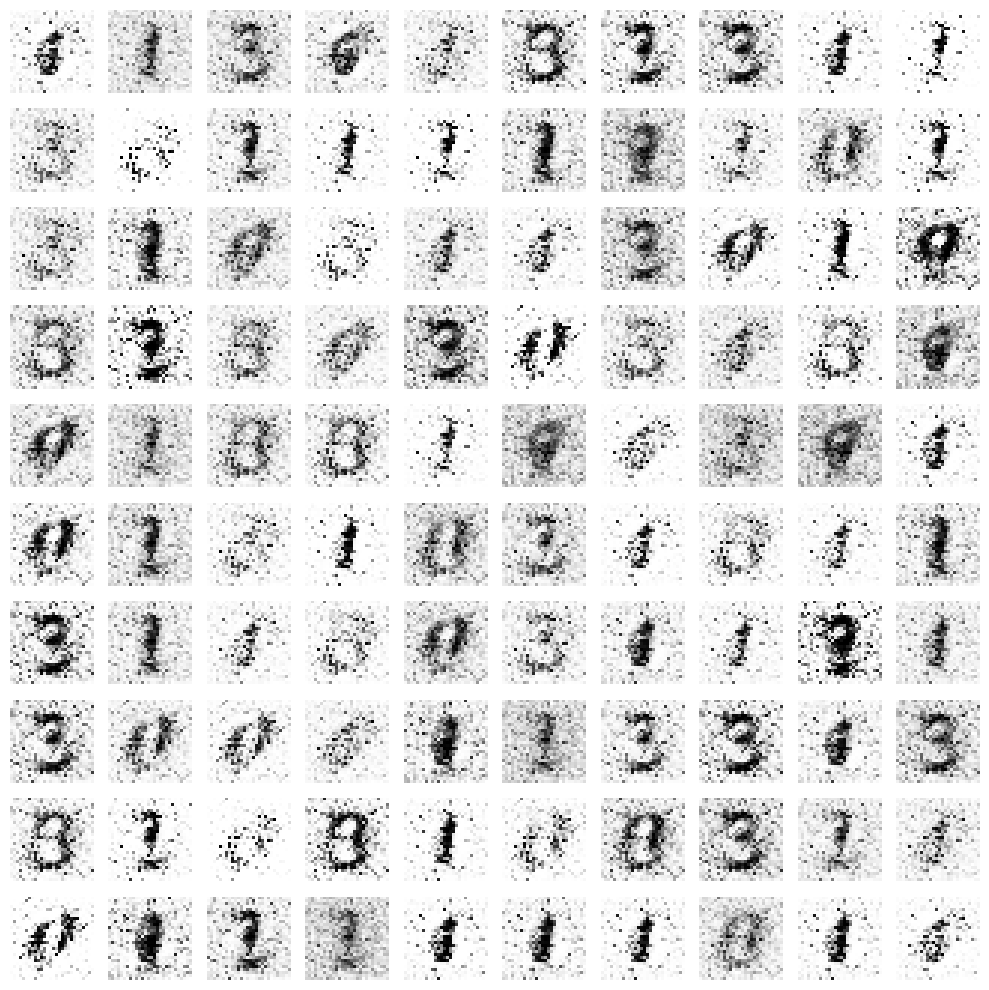

In [51]:
train(10, 128)